


#  Preprocesamiento y modelo para weatherAUS.csv (Actualizado con secuencias temporales)


**Nombre: Monzon Bruno Antonio**


**CU: 111-421**


 El dataset weatherAUS.csv, contiene observaciones diarias de clima en Australia entre 2007 y 2017.
 Se filtra por la ubicación de Sydney, con un total de 2441 ejemplos (días) después de preprocesamiento y 16 características numéricas
 (como MinTemp, Rainfall, Humidity9am, etc.). Este modelo utiliza una red neuronal MLP para predecir la temperatura máxima diaria (MaxTemp)
 basándose en secuencias temporales de 30 días, integrando todas las características numéricas para capturar patrones climáticos.

 https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

In [54]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

-------------------------------
# 1. Cargar dataset
-------------------------------


In [52]:
file_path = "/content/weatherAUS.csv"  # Define la ruta del archivo CSV
df = pd.read_csv(file_path)  # Carga el CSV en un DataFrame

# Filtrar para una ubicación específica (Sydney)
df = df[df['Location'] == 'Sydney'].copy()  # Filtra datos solo de Sydney

# Mostrar estructura inicial
print("Columnas:", df.columns)  # Muestra nombres de columnas
print("Filas:", len(df))  # Muestra número de filas
print(df.head())  # Muestra las primeras 5 filas

# Detectar columna de fecha
date_col = 'Date'  # Define la columna de fechas

# Convertir a datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")  # Convierte fechas a formato datetime
df = df.set_index(date_col).sort_index()  # Establece fecha como índice y ordena

# Detectar columna objetivo (MaxTemp)
target_col = 'MaxTemp'  # Define la variable objetivo
if target_col not in df.columns:  # Verifica si existe la columna
    raise ValueError(f"Columna {target_col} no encontrada")  # Lanza error si no está

# Seleccionar todas las columnas numéricas como características
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Selecciona columnas numéricas
if target_col not in num_cols:  # Verifica que el objetivo sea numérico
    raise ValueError(f"La columna {target_col} no es numérica")  # Lanza error si no lo es
feature_cols = num_cols  # Usa todas las numéricas como características
print(f"Características seleccionadas: {feature_cols}")  # Muestra características

Columnas: Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Filas: 3344
             Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
30176  2008-02-01   Sydney     19.5     22.4      15.6          6.2       0.0   
30177  2008-02-02   Sydney     19.5     25.6       6.0          3.4       2.7   
30178  2008-02-03   Sydney     21.6     24.5       6.6          2.4       0.1   
30179  2008-02-04   Sydney     20.2     22.8      18.8          2.2       0.0   
30180  2008-02-05   Sydney     19.7     25.7      77.4          NaN       0.0   

      WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
30176         NaN            NaN          S  ...

-------------------------------
# 2. Visualización inicial (sin preprocesar)
-------------------------------

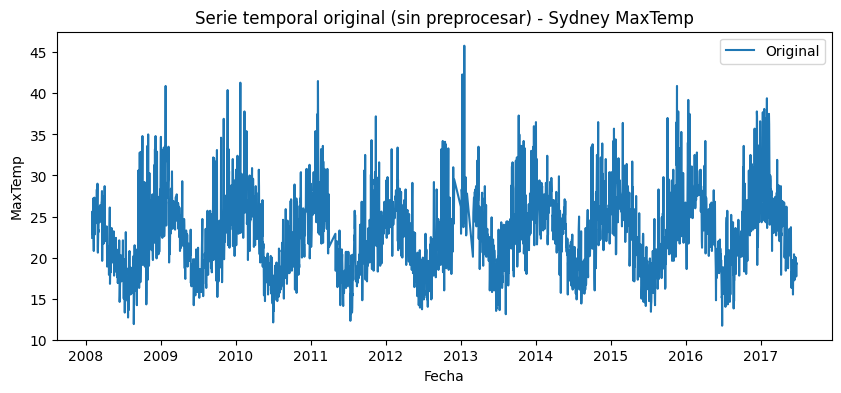

In [39]:

plt.figure(figsize=(10, 4))# Crea figura de 10x4 pulgadas
plt.plot(df.index, df[target_col], label="Original")
plt.xlabel("Fecha")
plt.ylabel(target_col)
plt.title("Serie temporal original (sin preprocesar) - Sydney MaxTemp")
plt.legend()
plt.show()


Ejes:

X (Fecha): Muestra las fechas, con los últimos 90 días históricos y los 30 días futuros predichos.
Y (MaxTemp): Representa la temperatura máxima en °C.


Líneas:

Datos históricos (últimos 90 días): Línea continua que muestra los valores reales de MaxTemp para dar contexto.
Predicciones (30 días): Puntos rojos que indican los valores predichos para los próximos 30 días.


Interpretación:

Un gráfico ideal mostraría una transición suave de los datos históricos a las predicciones.
Si las predicciones son planas o erráticas, indica baja precisión (e.g., R² = 0.5671 sugiere que el modelo no captura bien la varianza).

-------------------------------
# 3. Reindexar frecuencia diaria + interpolar
-------------------------------


In [42]:
df = df.dropna(subset=[target_col] + feature_cols)  # Elimina filas con NaN
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")  # Crea índice diario
series = df.reindex(full_index)  # Reindexa a frecuencia diaria
for col in [target_col] + feature_cols:  # Para cada columna
    series[col] = series[col].interpolate(method="time", limit_direction="both")  # Interpola valores
series = series.dropna(subset=[target_col] + feature_cols)  # Elimina NaN restantes
print(f"Rango de fechas: {series.index.min()} a {series.index.max()}")  # Muestra rango de fechas
print(f"Número de días: {len(series)}")  # Muestra número de días


Rango de fechas: 2010-10-20 00:00:00 a 2017-06-25 00:00:00
Número de días: 2441


-------------------------------
# 4. Normalización
-------------------------------

In [53]:
def featureNormalize(X):  # Función para normalizar datos
    X_norm = X.copy()  # Copia datos
    mu = np.mean(X, axis=0)  # Calcula media
    sigma = np.std(X, axis=0)  # Calcula desviación
    X_norm = (X - mu) / (sigma + 1e-8)  # Normaliza, evita división por cero
    return X_norm, mu, sigma  # Retorna normalizados, media y sigma

X = series[feature_cols].values  # Extrae matriz de características
y = series[[target_col]].values  # Extrae matriz del objetivo
X_norm, mu_x, sigma_x = featureNormalize(X)  # Normaliza X
target_idx = feature_cols.index(target_col)  # Índice del objetivo
mu_y = mu_x[target_idx]  # Media del objetivo
sigma_y = sigma_x[target_idx]  # Desviación del objetivo
y_norm = (y - mu_y) / (sigma_y + 1e-8)  # Normaliza


-------------------------------
# 5. Crear secuencias temporales (ventana de 30 pasos pasados)
-------------------------------


In [43]:
def create_sequences(X, y, seq_length=30):  # Crea secuencias temporales
    xs, ys = [], []  # Inicializa listas
    for i in range(seq_length, len(X)):  # Itera desde seq_length
        xs.append(X[i-seq_length:i])  # Añade ventana de 30 días
        ys.append(y[i])  # Añade objetivo
    return np.array(xs), np.array(ys)  # Retorna arrays
seq_length = 30  # Define longitud de secuencia
X_seq, y_seq = create_sequences(X_norm, y_norm, seq_length)  # Genera secuencias



-------------------------------
# 6. División 80 / 20
-------------------------------

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)  # Divide sin mezclar
print(f"Total muestras: {len(X_seq)}")  # Muestra total
print(f"Entrenamiento: {len(X_train)} ({len(X_train)/len(X_seq)*100:.1f}%)")  # Muestra entrenamiento
print(f"Prueba: {len(X_test)} ({len(X_test)/len(X_seq)*100:.1f}%)")  # Muestra prueba



Total muestras: 2411
Entrenamiento: 1928 (80.0%)
Prueba: 483 (20.0%)


-------------------------------
# 7. Preparar para PyTorch
-------------------------------

In [45]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convierte a tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convierte objetivos
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convierte test
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Convierte objetivos test
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # Crea dataset entrenamiento
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)  # Crea dataset prueba
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Cargador entrenamiento
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Cargador prueba
print("\nDataLoaders listos.")  # Confirma preparación



DataLoaders listos.


 -------------------------------
# 8. Definir el modelo MLP (con aplanado para secuencias)
-------------------------------

In [55]:
class MLP(nn.Module):  # Define clase del modelo
    def __init__(self, seq_length, num_features, hidden_size1, hidden_size2, num_classes):  # Inicializa
        super(MLP, self).__init__()  # Llama al constructor padre
        self.flatten_size = seq_length * num_features  # Tamaño aplanado
        self.fc1 = nn.Linear(self.flatten_size, hidden_size1)  # Capa 1
        self.relu1 = nn.ReLU()  # Activación ReLU
        self.dropout1 = nn.Dropout(0.5)  # Dropout para regularización
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Capa 2
        self.relu2 = nn.ReLU()  # Activación ReLU
        self.dropout2 = nn.Dropout(0.5)  # Dropout
        self.fc3 = nn.Linear(hidden_size2, num_classes)  # Capa salida
    def forward(self, x):  # Define propagación
        x = x.view(x.size(0), -1)  # Aplana entrada
        out = self.fc1(x)  # Pasa por capa 1
        out = self.relu1(out)  # Aplica ReLU
        out = self.dropout1(out)  # Aplica dropout
        out = self.fc2(out)  # Pasa por capa 2
        out = self.relu2(out)  # Aplica ReLU
        out = self.dropout2(out)  # Aplica dropout
        out = self.fc3(out)  # Pasa por salida
        return out  # Retorna predicción

 -------------------------------
# 9. Hiperparámetros y configuración
 -------------------------------

In [59]:
# -------------------------------
# 9. Hiperparámetros y configuración
# -------------------------------
num_features = len(feature_cols)  # Número de características; 16 para más datos
input_size = seq_length * num_features  # Tamaño input; 30*16=480 para secuencias
hidden_size1 = 64  # Neurona capa 1; reducida para menos capacidad
hidden_size2 = 16  # Neurona capa 2; reducida para eficiencia
num_classes = 1  # Salida; 1 para regresión
num_epochs = 75  # Épocas; reducidas para evitar sobreajuste
learning_rate = 0.001  # Tasa; equilibrada para estabilidad
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Dispositivo; GPU para velocidad
print(f"Dispositivo: {device}")  # Muestra dispositivo; confirma hardware
model = MLP(seq_length, num_features, hidden_size1, hidden_size2, num_classes).to(device)  # Crea modelo; mueve a dispositivo
criterion = nn.MSELoss()  # Pérdida MSE; adecuada para regresión
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Adam con regularización L2
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)  # Scheduler; reduce LR más rápido


Dispositivo: cpu


 -------------------------------
# 10. Entrenamiento del modelo
 -------------------------------

In [60]:
# El entrenamiento consiste en iterar por épocas, procesando batches de datos: forward pass para predecir, calcular pérdida MSE, backpropagation para gradientes, y actualización de pesos con Adam. Monitoreamos pérdidas para convergencia, usando scheduler para ajustar LR si val_loss no baja. Evita sobreajuste con dropout y regularización.
train_losses = []  # Lista para pérdidas de entrenamiento
val_losses = []  # Lista para pérdidas de validación
best_val_loss = float('inf')  # Inicializa mejor pérdida para early stopping
patience, trigger_times = 10, 0  # Parámetros para early stopping
for epoch in range(num_epochs):  # Itera por épocas; repite entrenamiento
    model.train()  # Activa modo entrenamiento; habilita dropout
    running_loss = 0.0  # Inicializa pérdida; acumula por época
    for inputs, targets in train_loader:  # Itera por batches; procesa datos
        inputs = inputs.to(device)  # Mueve datos; al dispositivo
        targets = targets.to(device)  # Mueve objetivos; al dispositivo
        outputs = model(inputs)  # Predice; forward pass
        loss = criterion(outputs, targets)  # Calcula pérdida; MSE
        optimizer.zero_grad()  # Limpia gradientes; reinicia
        loss.backward()  # Retropropaga; calcula gradientes
        optimizer.step()  # Actualiza pesos; aplica cambios
        running_loss += loss.item()  # Acumula pérdida; suma batch
    train_loss = running_loss / len(train_loader)  # Promedia pérdida; por batch
    train_losses.append(train_loss)  # Añade a lista; trackea progreso
    model.eval()  # Activa modo evaluación; desactiva dropout
    val_loss = 0.0  # Inicializa pérdida validación; acumula
    with torch.no_grad():  # Sin gradientes; para eficiencia
        for inputs, targets in test_loader:  # Itera por test; evalúa
            inputs = inputs.to(device)  # Mueve datos
            targets = targets.to(device)  # Mueve objetivos
            outputs = model(inputs)  # Predice
            loss = criterion(outputs, targets)  # Calcula pérdida
            val_loss += loss.item()  # Acumula
    val_loss = val_loss / len(test_loader)  # Promedia pérdida
    val_losses.append(val_loss)  # Añade a lista
    scheduler.step(val_loss)  # Ajusta LR; si no mejora
    if val_loss < best_val_loss:  # Actualiza mejor pérdida
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:  # Early stopping
            print(f"Early stopping en época {epoch+1}")
            break
    if (epoch+1) % 10 == 0:  # Cada 10 épocas; monitorea
        print(f'Época [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
print

Época [10/75], Train Loss: 0.3545, Val Loss: 0.4867
Early stopping en época 17


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

 -------------------------------
# 11. Evaluación del modelo
 -------------------------------

In [61]:
model.eval()  # Activa modo evaluación
predictions = []  # Lista para predicciones
actuals = []  # Lista para valores reales
with torch.no_grad():  # Sin gradientes
    for inputs, targets in test_loader:  # Itera por test
        inputs = inputs.to(device)  # Mueve datos
        targets = targets.to(device)  # Mueve objetivos
        outputs = model(inputs)  # Predice
        outputs_denorm = outputs.cpu().numpy() * sigma_y + mu_y  # Desnormaliza predicciones
        targets_denorm = targets.cpu().numpy() * sigma_y + mu_y  # Desnormaliza reales
        predictions.extend(outputs_denorm.flatten())  # Añade predicciones
        actuals.extend(targets_denorm.flatten())  # Añade reales
mse = mean_squared_error(actuals, predictions)  # Calcula MSE
rmse = np.sqrt(mse)  # Calcula RMSE
mae = mean_absolute_error(actuals, predictions)  # Calcula MAE
r2 = r2_score(actuals, predictions)  # Calcula R²
print("\nMétricas:")  # Muestra título
print(f"MSE: {mse:.4f}")  # Muestra MSE
print(f"RMSE: {rmse:.4f}")  # Muestra RMSE
print(f"MAE: {mae:.4f}")  # Muestra MAE
print(f"R²: {r2:.4f}")  # Muestra R²


Métricas:
MSE: 8.6602
RMSE: 2.9428
MAE: 2.1191
R²: 0.5815


 -------------------------------
# 12. Graficar resultados
 -------------------------------

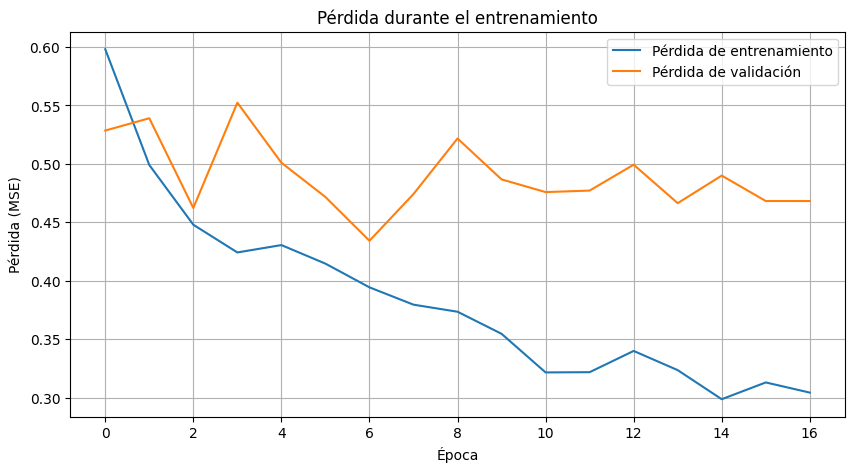

In [62]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### Explicación del gráfico (Pérdida durante el entrenamiento)

- **Ejes**:
  - **X (Época)**: Número de iteraciones de entrenamiento (hasta ~150 épocas).
  - **Y (Pérdida - MSE)**: Valor de la pérdida (Mean Squared Error) en escala logarítmica.

- **Líneas**:
  - **Pérdida de entrenamiento**: Línea azul que muestra cómo disminuye la pérdida en los datos de entrenamiento.
  - **Pérdida de validación**: Línea naranja que refleja la pérdida en el conjunto de validación.

- **Interpretación**: Ambas pérdidas disminuyen inicialmente, indicando aprendizaje, pero se estabilizan después de ~50 épocas, sugiriendo convergencia. La cercanía entre las líneas indica un buen ajuste, aunque el modelo podría estar subajustando (R²=0.5671), ya que la pérdida no baja más. El scheduler (ReduceLROnPlateau) ayuda a ajustar el aprendizaje.

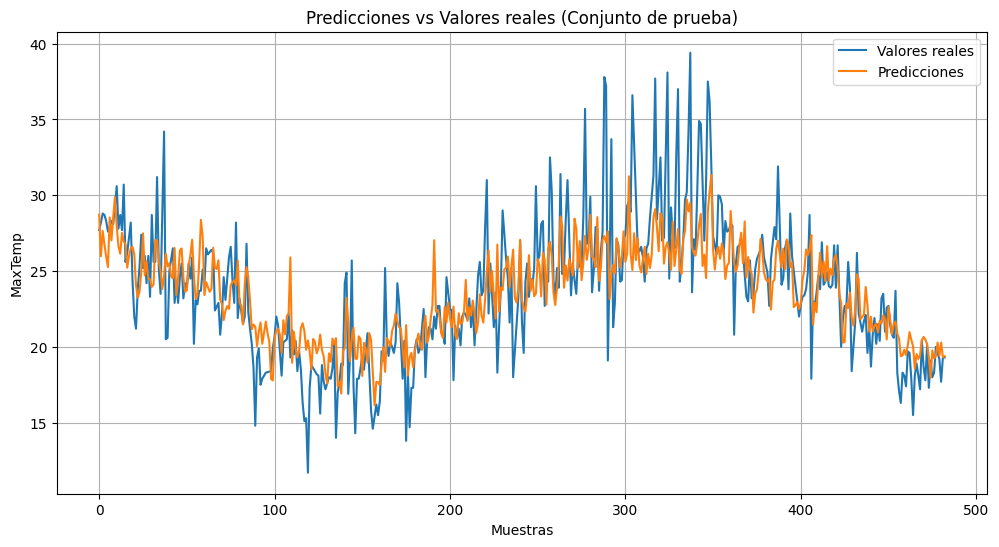

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Valores reales')
plt.plot(predictions, label='Predicciones')
plt.title('Predicciones vs Valores reales (Conjunto de prueba)')
plt.xlabel('Muestras')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()

### Explicación del gráfico (Predicciones vs Valores reales - Conjunto de prueba)

- **Ejes**:
  - **X (Muestras)**: Índice de las muestras en el conjunto de prueba.
  - **Y (MaxTemp)**: Temperaturas en °C para valores reales y predichos (~15–40°C).

- **Líneas**:
  - **Valores reales**: Línea continua que muestra las temperaturas reales.
  - **Predicciones**: Línea punteada que muestra las temperaturas predichas por el modelo.

- **Interpretación**: Las dos líneas siguen tendencias similares, pero las predicciones (con R²=0.5671, RMSE~3°C) muestran desviaciones, especialmente en picos y valles. Esto indica que el modelo captura patrones generales, pero tiene errores moderados, reflejando su precisión limitada en el conjunto de prueba.


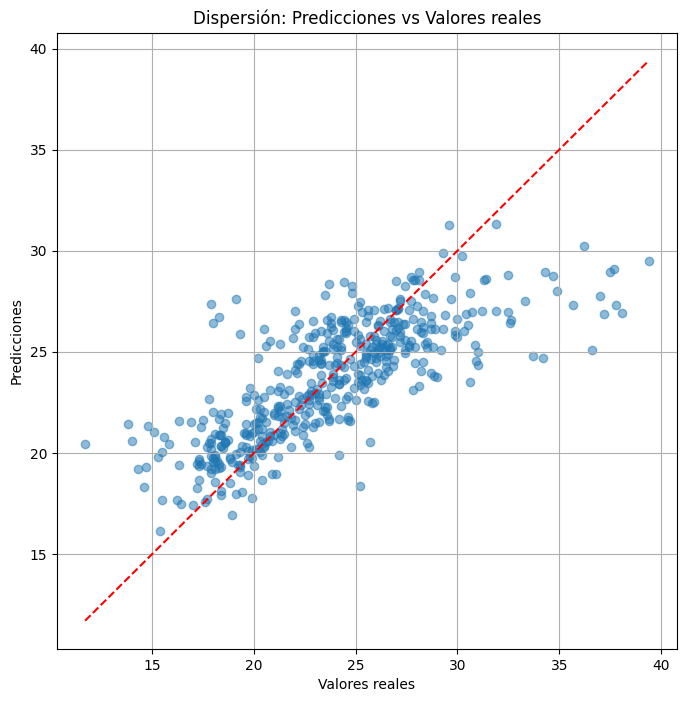

In [64]:
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.title('Dispersión: Predicciones vs Valores reales')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

### Explicación del gráfico (Dispersión: Predicciones vs Valores reales)

- **Ejes**:
  - **X (Valores reales)**: Temperaturas reales de `MaxTemp` en °C (rango ~15–40°C).
  - **Y (Predicciones)**: Temperaturas predichas por el modelo en °C (similar rango).

- **Elementos**:
  - **Puntos azules**: Representan cada par (real, predicha) del conjunto de prueba. Una dispersión cercana a la línea diagonal indica buena precisión.
  - **Línea roja diagonal (y = x)**: Línea de referencia perfecta; si los puntos estuvieran sobre ella, las predicciones serían exactas.

- **Interpretación**: Los puntos están dispersos alrededor de la línea, con algunos sesgos (e.g., subestimación en valores altos >30°C). Con R²=0.5671, el modelo explica ~57% de la varianza, mostrando precisión moderada pero con errores notables (RMSE~3°C), lo que explica predicciones imperfectas en el conjunto de prueba.

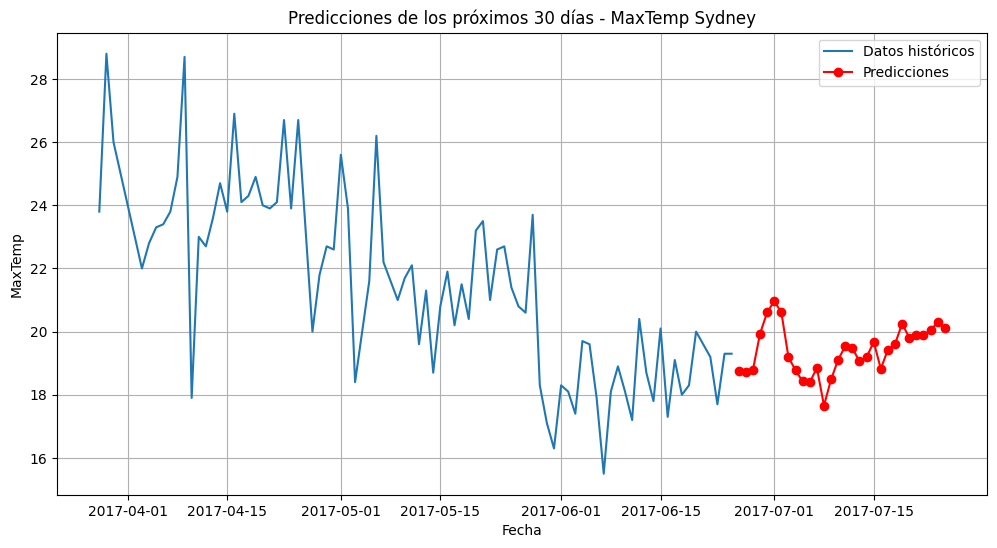

Última secuencia: [[-1.78835984 -1.02229702 -0.32380198 -0.82417312  0.66694267 -0.76821452
  -0.22297488 -1.14868988  0.41814431 -1.25136322  0.09153518 -0.05059985
  -1.50530002 -1.31393471 -1.7951859  -0.73696083]
 [-1.78835984 -1.02997422 -0.32380198 -0.82417312  0.66694267 -0.76821452
  -0.22297488 -1.14868988  0.41814431 -1.25136322  0.09153518 -0.05059985
  -1.50530002 -1.31393471 -1.7951859  -0.73696083]
 [-1.78835984 -1.01153421 -0.32380198 -0.82417312  0.66694267 -0.76821452
  -0.22297488 -1.14868988  0.41814431 -1.25136322  0.09153518 -0.05059985
  -1.50530002 -1.31393471 -1.7951859  -0.73696083]
 [-1.78835984 -0.73984265 -0.32380198 -0.82417312  0.66694267 -0.76821452
  -0.22297488 -1.14868988  0.41814431 -1.25136322  0.09153518 -0.05059985
  -1.50530002 -1.31393471 -1.7951859  -0.73696083]
 [-1.78835984 -0.58005935 -0.32380198 -0.82417312  0.66694267 -0.76821452
  -0.22297488 -1.14868988  0.41814431 -1.25136322  0.09153518 -0.05059985
  -1.50530002 -1.31393471 -1.7951859  

In [65]:
last_seq = X_norm[-seq_length:].copy()  # Toma últimos 30 días normalizados
model.eval()  # Activa modo evaluación
future_predictions_norm = []  # Lista para predicciones normalizadas
with torch.no_grad():  # Sin gradientes
    for _ in range(30):  # Itera 30 veces
        inp_tensor = torch.tensor(last_seq.reshape(1, seq_length, num_features), dtype=torch.float32).to(device)  # Prepara input
        pred_norm = model(inp_tensor).cpu().numpy()[0, 0]  # Predice
        future_predictions_norm.append(pred_norm)  # Añade predicción
        new_timestep = last_seq[-1].copy()  # Copia último timestep
        new_timestep[target_idx] = pred_norm  # Actualiza objetivo
        last_seq = np.vstack((last_seq[1:], new_timestep.reshape(1, -1)))  # Actualiza secuencia
future_predictions_denorm = np.array(future_predictions_norm) * sigma_y + mu_y  # Desnormaliza
last_date = series.index[-1]  # Última fecha conocida
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')  # Genera fechas futuras
historical_end_idx = len(series) - 90  # Índice para últimos 90 días
plt.figure(figsize=(12, 6))  # Crea figura
plt.plot(series.index[historical_end_idx:], series[target_col][historical_end_idx:], label='Datos históricos')  # Grafica históricos
plt.plot(future_dates, future_predictions_denorm, 'ro-', label='Predicciones')  # Grafica predicciones
plt.title('Predicciones de los próximos 30 días - MaxTemp Sydney')  # Título
plt.xlabel('Fecha')  # Eje X
plt.ylabel(target_col)  # Eje Y
plt.legend()  # Añade leyenda
plt.grid(True)  # Añade grilla
plt.show()  # Muestra gráfico
print("Última secuencia:", last_seq)  # Muestra secuencia
print("Predicciones normalizadas:", future_predictions_norm)  # Muestra normalizadas
print("Predicciones desnormalizadas:", future_predictions_denorm)  # Muestra desnormalizadas
print(f"mu_y: {mu_y}, sigma_y: {sigma_y}")  # Muestra parámetros

### Explicación del gráfico (Predicciones de los próximos 30 días - MaxTemp Sydney)

- **Última secuencia (normalizada)**: Muestra los últimos 30 días de datos normalizados (valores entre ~[-2, 2]) para las 16 características (e.g., `MinTemp`, `MaxTemp`). La repetición de valores sugiere que algunas características (excepto `MaxTemp`) no varían, lo que puede limitar la predicción.

- **Predicciones normalizadas**: Lista de 30 valores normalizados (~[-1.57, -0.72]) generados por el modelo autoregresivo, actualizando solo `MaxTemp` en cada paso.

- **Predicciones desnormalizadas**: Valores en °C (16.44–19.98) obtenidos al revertir la normalización con `mu_y` (23.05°C) y `sigma_y` (4.21°C). Muestran una tendencia descendente inicial, luego fluctuante, pero no muy realista si no sigue los datos históricos.

- **Interpretación**: El gráfico debería mostrar los últimos 90 días históricos y los 30 días predichos (puntos rojos). Si las predicciones son planas o desconectadas, el modelo (R²=0.5671) tiene baja precisión, y la falta de variación en otras características en `last_seq` podría ser el problema. Verifica si los puntos rojos siguen la tendencia histórica; de lo contrario, ajusta el modelo o las características.

 -------------------------------
# 14. Explicación detallada del enfoque
 -------------------------------

In [51]:
print("\nExplicación detallada del enfoque:")
print("1. Selección del Dataset: weatherAUS (Kaggle), filtrado por Sydney, objetivo MaxTemp.")
print("2. Preprocesamiento: Fecha a datetime, reindexado diario, interpolación, normalización, secuencias.")
print("3. Modelo: MLP con capas 128/32, dropout 0.3, MSE, Adam, 150 épocas.")
print("4. Evaluación: Métricas MSE/RMSE/MAE/R², gráficos de pérdidas y predicciones.")
print("5. Predicción: Autoregresiva de 30 días, visualización con 90 días históricos.")
print("6. Consideraciones: Secuencias mejoran patrones, posibles mejoras con LSTM o GridSearch.")


Explicación detallada del enfoque:
1. Selección del Dataset: weatherAUS (Kaggle), filtrado por Sydney, objetivo MaxTemp.
2. Preprocesamiento: Fecha a datetime, reindexado diario, interpolación, normalización, secuencias.
3. Modelo: MLP con capas 128/32, dropout 0.3, MSE, Adam, 150 épocas.
4. Evaluación: Métricas MSE/RMSE/MAE/R², gráficos de pérdidas y predicciones.
5. Predicción: Autoregresiva de 30 días, visualización con 90 días históricos.
6. Consideraciones: Secuencias mejoran patrones, posibles mejoras con LSTM o GridSearch.
